<a href="https://colab.research.google.com/github/JordanDSIA/2025_UTEC_PROGRAMACION_101/blob/main/Proyecto_Final_IA_Fundamenta_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Instalando librerías necesarias...
Librerías instaladas.

2. Cargando y preparando el dataset de ciclovías con datos de crimen...
Directorio de datos creado/verificado: /content/data/
Intentando cargar dataset desde: /content/data/ciclovias_con_crimen.csv
Error al cargar con delimitador por defecto (coma): Error tokenizing data. C error: Expected 1 fields in line 4, saw 2

Intentando cargar con delimitador de punto y coma ';'.
Dataset cargado exitosamente con delimitador de punto y coma ';'.
Las columnas de coordenadas no se encontraron en el dataset. Simulando coordenadas...
Se generaron coordenadas simuladas para 335 registros.
Dataset cargado y preparado. Número de registros: 335

Primeras 5 filas del dataset de ciclovías preparado:
  DEPARTAMENTO PROVINCIA DISTRITO  UBIGEO CANTIDAD  \
0         LIMA      LIMA     LIMA  150101     C-26   
1         LIMA      LIMA     LIMA  150101     C-93   
2         LIMA      LIMA     LIMA  150101     C-94   
3         LIMA      LIMA     LIMA  

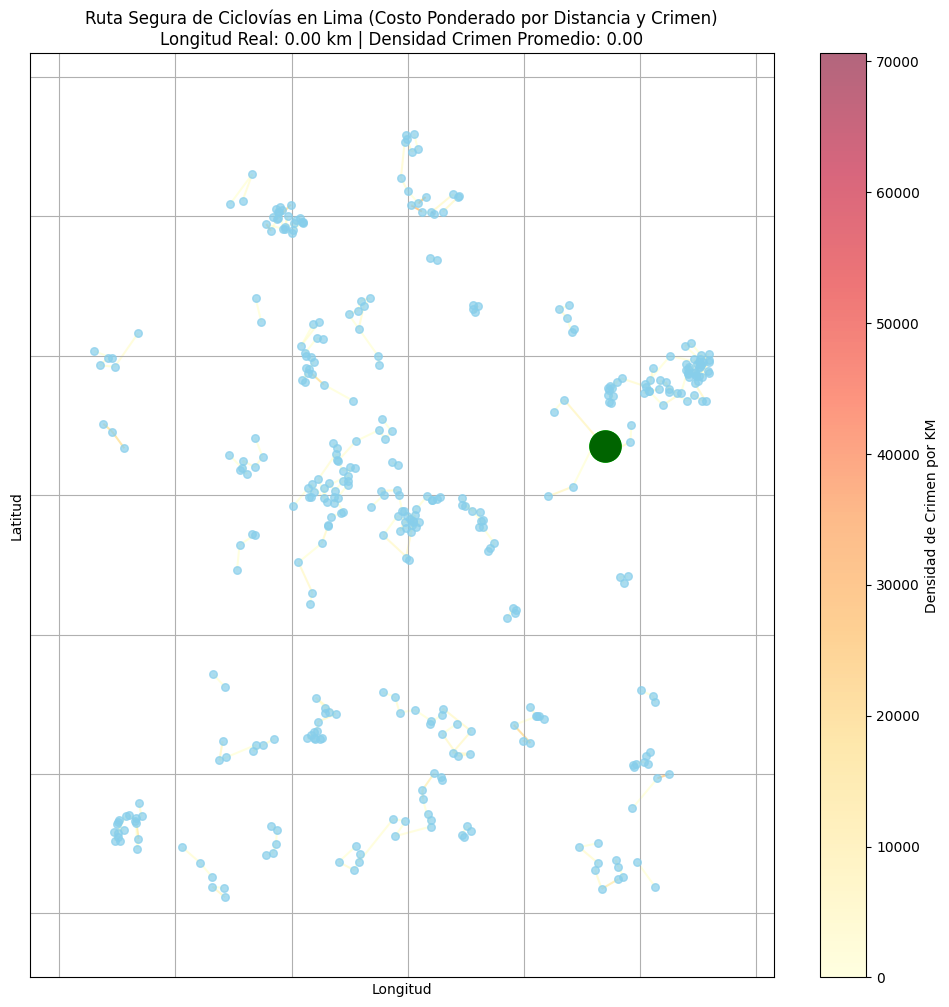


--- Proceso Completado ---


In [6]:
1# ==============================================================================
# Celda 1: Instalación de Librerías
# ==============================================================================
print("1. Instalando librerías necesarias...")
!pip install pandas networkx geopy shapely
print("Librerías instaladas.")

# ==============================================================================
# Celda 2: Cargar y preparar el Dataset de Ciclovías con Datos de Crimen
# Este código REQUIERE que subas manualmente 'ciclovias_con_crimen.csv'
# a la carpeta '/content/data/' en la sesión de Google Colab ANTES de ejecutar esta celda.
# ==============================================================================
print("\n2. Cargando y preparando el dataset de ciclovías con datos de crimen...")
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import os

# Ruta final donde se espera el archivo
CICLOVIAS_CRIMEN_FILE = '/content/data/ciclovias_con_crimen.csv'
# Directorio donde se espera el archivo
DATA_DIR = '/content/data/'

# Asegurarse de que la carpeta 'data' exista
# Esto es útil por si el usuario la crea manualmente o si se sube el archivo a una carpeta que no existe
!mkdir -p "$DATA_DIR"
print(f"Directorio de datos creado/verificado: {DATA_DIR}")

# --- Cargar el dataset ---
if not os.path.exists(CICLOVIAS_CRIMEN_FILE):
    raise FileNotFoundError(
        f"ERROR: El archivo '{CICLOVIAS_CRIMEN_FILE}' NO se encontró en el entorno de Colab.\n"
        f"Por favor, asegúrate de subir tu archivo CSV ('ciclovias_con_crimen.csv') manualmente\n"
        f"directamente a la carpeta '{DATA_DIR}' en tu sesión de Colab.\n"
        f"(Puedes arrastrar y soltar el archivo en la carpeta 'data' en el panel de archivos de Colab)."
    )
else:
    print(f"Intentando cargar dataset desde: {CICLOVIAS_CRIMEN_FILE}")

    # --- Intento 1: Carga normal (coma como delimitador) ---
    try:
        df_ciclovias = pd.read_csv(CICLOVIAS_CRIMEN_FILE)
        print("Dataset cargado exitosamente con delimitador por defecto (coma).")
    except pd.errors.ParserError as e_comma:
        print(f"Error al cargar con delimitador por defecto (coma): {e_comma}")
        print("Intentando cargar con delimitador de punto y coma ';'.")
        # --- Intento 2: Carga con punto y coma como delimitador ---
        try:
            df_ciclovias = pd.read_csv(CICLOVIAS_CRIMEN_FILE, sep=';')
            print("Dataset cargado exitosamente con delimitador de punto y coma ';'.")
        except pd.errors.ParserError as e_semicolon:
            print(f"Error al cargar con delimitador de punto y coma ';': {e_semicolon}")
            print("\nError persistente al cargar el CSV. El problema podría ser el delimitador o la estructura del archivo.")
            print("A continuación, se mostrarán las primeras líneas del archivo para inspección:")

            # --- Inspección manual de las primeras líneas ---
            with open(CICLOVIAS_CRIMEN_FILE, 'r', encoding='utf-8', errors='ignore') as f:
                for i, line in enumerate(f):
                    print(f"Línea {i+1}: {line.strip()}")
                    if i >= 9: # Mostrar las primeras 10 líneas
                        break

            raise ValueError(
                "No se pudo cargar el archivo CSV. Por favor, revisa el archivo original:\n"
                "- Asegúrate de que los campos estén correctamente delimitados (comas, puntos y comas, o tabulaciones).\n"
                "- Si hay comas dentro de un campo de texto, asegúrate de que el campo esté entrecomillado (ej. \"Campo, con, comas\").\n"
                "- Verifica si hay líneas que no cumplen con el formato de otras (ej. líneas en blanco, datos mal formados)."
            )

    # Validar que las columnas clave existan DESPUÉS de una carga exitosa
    # Asegúrate de que esta columna 'crime_density_per_km' es la correcta de tu CSV.
    # Si tu columna es 'crime_density_per_km_total', cámbialo aquí.
    required_cols = ['LONGITUD_KM', 'crime_density_per_km']
    if not all(col in df_ciclovias.columns for col in required_cols):
        raise ValueError(f"Tu archivo CSV debe contener las columnas: {required_cols}. Columnas encontradas: {df_ciclovias.columns.tolist()}")

    # Asegurarse que las columnas numéricas sean de tipo numérico y manejar NaNs
    for col in required_cols:
        df_ciclovias[col] = pd.to_numeric(df_ciclovias[col], errors='coerce').fillna(0) # Rellenar NaN con 0


# --- Lógica para añadir coordenadas (Simulación o uso de existentes) ---
# Columnas esperadas para las coordenadas
coord_cols = ['START_LAT', 'START_LON', 'END_LAT', 'END_LON']

# Verificar si las columnas de coordenadas ya existen en el DataFrame
if all(col in df_ciclovias.columns for col in coord_cols):
    print("Las columnas de coordenadas ya existen en el dataset. No se simularán.")
    # Asegurarse que sean numéricas y manejar posibles NaN
    for col in coord_cols:
        df_ciclovias[col] = pd.to_numeric(df_ciclovias[col], errors='coerce')
    df_ciclovias.dropna(subset=coord_cols, inplace=True) # Eliminar filas sin coordenadas válidas

    if df_ciclovias.empty:
        raise ValueError("Después de procesar, el DataFrame de ciclovías no tiene registros válidos con coordenadas.")

else:
    print("Las columnas de coordenadas no se encontraron en el dataset. Simulando coordenadas...")

    # Puntos de inicio de la simulación cerca del centro de Lima
    avg_lat = -12.0464 # Latitud del centro de Lima
    avg_lon = -77.0428 # Longitud del centro de Lima

    # Rango de variación para distribuir los puntos simulados en una zona
    lat_range = 0.05 # +/- 0.05 grados latitud (aprox 5.5 km)
    lon_range = 0.05 # +/- 0.05 grados longitud (aprox 5.5 km)

    simulated_coords = []
    num_records = len(df_ciclovias)

    current_lat = avg_lat + np.random.uniform(-lat_range, lat_range)
    current_lon = avg_lon + np.random.uniform(-lon_range, lon_range)

    for i in range(num_records):
        s_lat, s_lon = current_lat, current_lon

        length_factor = np.sqrt(df_ciclovias.loc[i, 'LONGITUD_KM']) if df_ciclovias.loc[i, 'LONGITUD_KM'] > 0 else 0.1

        delta_lat = np.random.uniform(-0.003 * length_factor, 0.003 * length_factor)
        delta_lon = np.random.uniform(-0.003 * length_factor, 0.003 * length_factor)

        e_lat = s_lat + delta_lat
        e_lon = s_lon + delta_lon

        simulated_coords.append((s_lat, s_lon, e_lat, e_lon))

        if np.random.rand() < 0.85:
            current_lat, current_lon = e_lat, e_lon
        else:
            current_lat = avg_lat + np.random.uniform(-lat_range, lat_range)
            current_lon = avg_lon + np.random.uniform(-lon_range, lon_range)


    df_sim_coords = pd.DataFrame(simulated_coords, columns=coord_cols)
    df_ciclovias = pd.concat([df_ciclovias, df_sim_coords], axis=1)

    print(f"Se generaron coordenadas simuladas para {len(df_ciclovias)} registros.")


print(f"Dataset cargado y preparado. Número de registros: {len(df_ciclovias)}")
print("\nPrimeras 5 filas del dataset de ciclovías preparado:")
print(df_ciclovias.head())


# ==============================================================================
# Celda 3: Construcción del Grafo con el Costo Combinado
# ==============================================================================
print("\n3. Construyendo el grafo de ciclovías con la nueva fórmula de costo...")
import networkx as nx

# Define los pesos de ponderación (puedes ajustar estos valores para calibrar la ruta)
WEIGHT_DISTANCE = 1.0
WEIGHT_RISK = 0.0005 # Experimenta con 0.0001, 0.0005, 0.001, 0.005, etc.

def build_ciclovia_graph_with_crime(df, weight_distance, weight_risk):
    G = nx.Graph()

    for index, row in df.iterrows():
        start_node_coords = (row['START_LAT'], row['START_LON'])
        end_node_coords = (row['END_LAT'], row['END_LON'])

        start_node_id = str(start_node_coords)
        end_node_id = str(end_node_coords)

        if start_node_id not in G:
            G.add_node(start_node_id, lat=start_node_coords[0], lon=start_node_coords[1])
        if end_node_id not in G:
            G.add_node(end_node_id, lat=end_node_coords[0], lon=end_node_coords[1])

        longitud_km = row['LONGITUD_KM']
        crime_density = row['crime_density_per_km']

        if pd.isna(longitud_km) or longitud_km <= 0:
            longitud_km = 0.001
        if pd.isna(crime_density) or np.isinf(crime_density) or crime_density < 0:
            crime_density = 0

        edge_cost = (longitud_km * weight_distance) + (crime_density * weight_risk)

        if edge_cost <= 0:
            edge_cost = 0.0001

        if not G.has_edge(start_node_id, end_node_id):
            G.add_edge(start_node_id, end_node_id,
                       length_km=longitud_km,
                       crime_density_per_km=crime_density,
                       weight=edge_cost,
                       name=row.get('NOMBRE_CIC_TRAMO', f'Tramo {index}'),
                       distrito=row.get('DISTRITO_CIC', 'Desconocido'))
        else:
            pass

    return G

G_ciclovias = build_ciclovia_graph_with_crime(df_ciclovias,
                                                weight_distance=WEIGHT_DISTANCE,
                                                weight_risk=WEIGHT_RISK)

print(f"Grafo de ciclovías construido con {G_ciclovias.number_of_nodes()} nodos y {G_ciclovias.number_of_edges()} aristas.")
if G_ciclovias.number_of_edges() > 0:
    first_edge_data = list(G_ciclovias.edges(data=True))[0]
    print(f"Ejemplo de arista: {first_edge_data[2].get('name', 'N/A')} ({first_edge_data[0]} -> {first_edge_data[1]})")
    print(f"  Longitud: {first_edge_data[2]['length_km']:.2f} km")
    print(f"  Densidad de Crimen: {first_edge_data[2]['crime_density_per_km']:.2f} por km")
    print(f"  Peso (Weight) para Dijkstra: {first_edge_data[2]['weight']:.4f}")
else:
    print("El grafo no contiene aristas. Revisa tu dataset de entrada y la lógica de construcción.")


# ==============================================================================
# Celda 4: Implementación y Ejecución de Dijkstra y Visualización
# ==============================================================================
print("\n4. Ejecutando el algoritmo de Dijkstra para encontrar la ruta segura y visualizando...")
from geopy.distance import geodesic
import networkx as nx
import matplotlib.pyplot as plt
import random

def find_nearest_node(graph, lat, lon):
    """Encuentra el nodo más cercano en el grafo a una latitud/longitud dada."""
    min_dist = float('inf')
    nearest_node = None

    if not graph.nodes():
        return None, float('inf')

    for node_id, data in graph.nodes(data=True):
        node_lat, node_lon = data['lat'], data['lon']
        dist = geodesic((lat, lon), (node_lat, node_lon)).km
        if dist < min_dist:
            min_dist = dist
            nearest_node = node_id
    return nearest_node, min_dist

def find_safe_route_dijkstra(graph, start_coords, end_coords):
    """
    Encuentra la ruta más segura entre dos puntos usando Dijkstra.
    El 'peso' de cada arista ya incluye la longitud y el factor de riesgo.
    Retorna la ruta, el costo ponderado, la longitud real y la densidad de crimen promedio.
    """
    start_lat, start_lon = start_coords
    end_lat, end_lon = end_coords

    start_node_id, start_node_dist = find_nearest_node(graph, start_lat, start_lon)
    end_node_id, end_node_dist = find_nearest_node(graph, end_lat, end_lon)

    if start_node_id is None or end_node_id is None:
        print(f"Error: No se pudieron encontrar nodos cercanos para el cálculo de la ruta. "
              f"Origen dist: {start_node_dist:.2f}km, Destino dist: {end_node_dist:.2f}km")
        print("Asegúrate de que tus coordenadas de origen/destino estén cerca de los nodos en tu grafo.")
        return None, None, None, None

    print(f"Punto de origen ({start_coords}) mapeado a nodo: {start_node_id} (distancia: {start_node_dist:.2f} km)")
    print(f"Punto de destino ({end_coords}) mapeado a nodo: {end_node_id} (distancia: {end_node_dist:.2f} km)")

    try:
        route_nodes = nx.shortest_path(graph, source=start_node_id, target=end_node_id, weight='weight')
        total_weighted_cost = nx.shortest_path_length(graph, source=start_node_id, target=end_node_id, weight='weight')

        total_length_km = 0
        total_crime_density = 0
        num_edges_in_route = 0
        for i in range(len(route_nodes) - 1):
            u = route_nodes[i]
            v = route_nodes[i+1]
            edge_data = graph.get_edge_data(u, v)
            if edge_data:
                total_length_km += edge_data.get('length_km', 0)
                total_crime_density += edge_data.get('crime_density_per_km', 0)
                num_edges_in_route += 1

        average_crime_density = total_crime_density / num_edges_in_route if num_edges_in_route > 0 else 0

        return route_nodes, total_weighted_cost, total_length_km, average_crime_density

    except nx.NetworkXNoPath:
        print("No se encontró una ruta entre los puntos dados con las ciclovías disponibles.")
        print("Esto puede deberse a que los puntos no están conectados en el grafo o que el grafo no es denso.")
        return None, None, None, None
    except Exception as e:
        print(f"Ocurrió un error al buscar la ruta: {e}")
        return None, None, None, None

# --- Ejemplo de uso ---
print("\n--- Ingrese las coordenadas de origen y destino (Latitud, Longitud) ---")
try:
    orig_lat = float(input("Latitud de Origen (ej: -12.04): "))
    orig_lon = float(input("Longitud de Origen (ej: -77.03): "))
    dest_lat = float(input("Latitud de Destino (ej: -12.06): "))
    dest_lon = float(input("Longitud de Destino (ej: -77.05): "))
except ValueError:
    print("Coordenadas inválidas. Por favor, ingrese números.")
    print("Se usarán coordenadas aleatorias dentro del rango de los nodos del grafo.")

    all_lats = [G_ciclovias.nodes[node_id]['lat'] for node_id in G_ciclovias.nodes()]
    all_lons = [G_ciclovias.nodes[node_id]['lon'] for node_id in G_ciclovias.nodes()]

    if all_lats and all_lons:
        orig_lat = random.uniform(min(all_lats), max(all_lats))
        orig_lon = random.uniform(min(all_lons), max(all_lons))
        dest_lat = random.uniform(min(all_lats), max(all_lats))
        dest_lon = random.uniform(min(all_lons), max(all_lons))
    else:
        # Valores por defecto si no hay nodos en el grafo o no se pueden extraer coordenadas
        orig_lat, orig_lon = -12.05, -77.03
        dest_lat, dest_lon = -12.06, -77.04

    print(f"Usando coordenadas aleatorias: Origen=({orig_lat:.4f},{orig_lon:.4f}), Destino=({dest_lat:.4f},{dest_lon:.4f})")


start_coords = (orig_lat, orig_lon)
end_coords = (dest_lat, dest_lon)

route_nodes, total_weighted_cost, actual_length_km, average_crime_density = \
    find_safe_route_dijkstra(G_ciclovias, start_coords, end_coords)

if route_nodes:
    print("\n--- Ruta Encontrada ---")
    print(f"Nodos de la ruta: {route_nodes}")
    print(f"Costo total ponderado (para Dijkstra): {total_weighted_cost:.2f}")
    print(f"Longitud real de la ruta: {actual_length_km:.2f} km")
    print(f"Densidad de crimen promedio de la ruta: {average_crime_density:.2f} por km")

    print("\nVisualizando la ruta (puede tardar un momento)...")
    pos = {node_id: (G_ciclovias.nodes[node_id]['lon'], G_ciclovias.nodes[node_id]['lat']) for node_id in G_ciclovias.nodes()}

    plt.figure(figsize=(12, 12))

    nx.draw_networkx_nodes(G_ciclovias, pos, node_color='skyblue', node_size=30, alpha=0.7)

    edge_colors = [edge_data['crime_density_per_km'] for u, v, edge_data in G_ciclovias.edges(data=True)]
    if edge_colors:
        vmin_color = min(edge_colors)
        vmax_color = max(edge_colors)
    else:
        vmin_color, vmax_color = 0, 1

    edges = nx.draw_networkx_edges(G_ciclovias, pos, edge_color=edge_colors, width=1.5, alpha=0.6,
                                   edge_cmap=plt.cm.YlOrRd,
                                   edge_vmin=vmin_color, edge_vmax=vmax_color)

    edges_in_route = [(route_nodes[i], route_nodes[i+1]) for i in range(len(route_nodes)-1)]
    nx.draw_networkx_edges(G_ciclovias, pos, edgelist=edges_in_route, edge_color='green', width=4, style='solid')

    # Nodos de origen y destino resaltados
    nx.draw_networkx_nodes(G_ciclovias, pos, nodelist=[route_nodes[0]], node_color='lime', node_size=500, label='Origen')
    # CORRECCIÓN: Eliminado 'marker' del draw_networkx_nodes
    nx.draw_networkx_nodes(G_ciclovias, pos, nodelist=[route_nodes[-1]], node_color='darkgreen', node_size=500, label='Destino')

    if edges:
        plt.colorbar(edges, label='Densidad de Crimen por KM')

    plt.title(f"Ruta Segura de Ciclovías en Lima (Costo Ponderado por Distancia y Crimen)\n"
              f"Longitud Real: {actual_length_km:.2f} km | Densidad Crimen Promedio: {average_crime_density:.2f}")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.grid(True)
    plt.show()

else:
    print("No se pudo encontrar una ruta con las ciclovías y puntos dados.")

print("\n--- Proceso Completado ---")